In [ ]:
 import sys, os
from contextlib import contextmanager
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout



with suppress_stdout():
  !pip install pmdarima
  !pip install --upgrade pandas
  !pip install scikit-learn==01.1.3

from google.colab import files,drive
import pandas as pd
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import sklearn

from sklearn.linear_model import LinearRegression



drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Thesis/New_Code Vol 2')
path='/content/drive/MyDrive/Thesis/Data Folder/Sorted_SKU.csv'
sorted=pd.read_csv(path)
sorted=sorted.set_axis(['SKU'], axis=1)


import data
import calc_elasticity
import forecastability
import hybrid
import dqn




Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for i in sorted.SKU[0:1]:
  df=data.item(i)

In [ ]:
dates = pd.date_range(start='2010-01-01', freq='MS', periods=len(df))
df.set_index(dates,inplace=True)
sales_ts = df['products_quantity']
data = pd.DataFrame(sales_ts.copy())
data.head()

,products_quantity
2010-01-01,21.0
2010-02-01,50.0
2010-03-01,43.0
2010-04-01,40.0
2010-05-01,37.0


In [ ]:
series = data['products_quantity'].tolist()
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 269
Test  data length : 68


In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import numpy as np
from numpy import asarray
from numpy import sqrt
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
from statsmodels.tsa.api import ExponentialSmoothing
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import preprocessing

In [ ]:

""" ETS Rolling Forecast """
predicted, resid_test = [], []
history = train
for t in range(len(test)):
    model_fit = ExponentialSmoothing(history ,seasonal_periods=52 ,trend='add', seasonal='add').fit()
    output = model_fit.forecast()
    y_hat_avg = output[0]
    resid_test.append(test[t] - output[0])
    predicted.append(y_hat_avg)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y_hat_avg, obs))
test_resid = []
for i in resid_test:
    test_resid.append(i)
plt.plot(test)
plt.plot(predicted, color='red')
plt.show()


In [ ]:
Forecasting

In [ ]:
train, test = series[0:size], series[size:len(series)]
model_fit = ExponentialSmoothing(history ,seasonal_periods=52 ,trend='add', seasonal='add').fit()
print(model_fit.summary())
""" plot residuals errors """
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
""" Hybrid Model """

window_size = 50

def make_model(window_size):
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(window_size,1)))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = make_model(50)

min_max_scaler = preprocessing.MinMaxScaler()
train = np.array(residuals).reshape(-1,1)
train_scaled = min_max_scaler.fit_transform(residuals)

train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])

new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_X = np.reshape(new_train_X, (new_train_X.shape[0], new_train_X.shape[1], 1))
new_train_Y = np.array(new_train_Y)
lstm_model.fit(new_train_X,new_train_Y, epochs=300, batch_size=32, validation_split = .05)

3/3 [==============================] - 0s 10ms/step


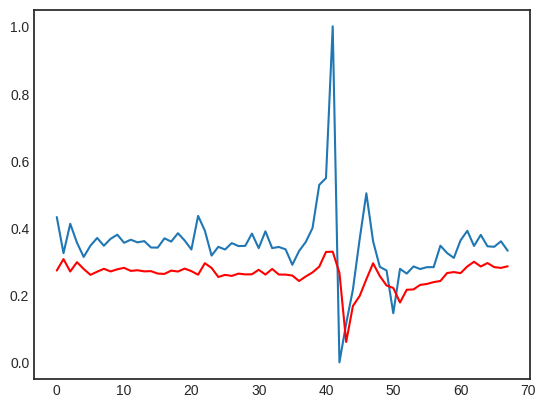

In [ ]:
test_extended = train.tolist()[-1*window_size:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(test_data)
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
    new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_X = np.reshape(new_test_X, (new_test_X.shape[0], new_test_X.shape[1], 1))
new_test_Y = np.array(new_test_Y)
predictions = lstm_model.predict(new_test_X)
predictions_rescaled=min_max_scaler.inverse_transform(predictions)
Y = pd.DataFrame(new_test_Y)
pred = pd.DataFrame(predictions)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(test_resid,predictions_rescaled)

In [ ]:
initial_profit = conv_rate*(np.sum(df["Avg_Price_per_unit"]*df["Average_units_sold"]) - np.sum(df['Cost_per_unit']*df["Average_units_sold"]))


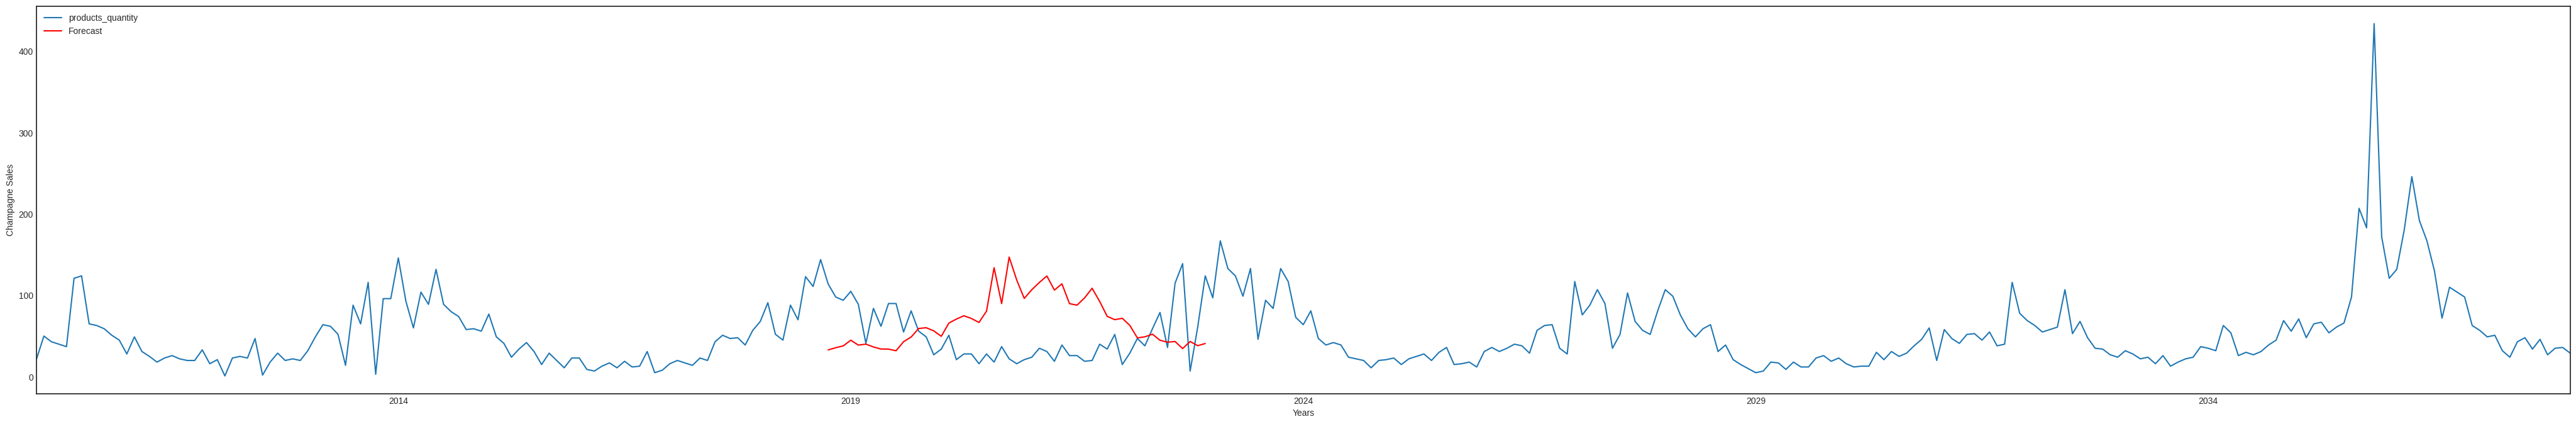

In [ ]:
Forecasting = model_fit.forecast(steps=52)
idx = pd.date_range(start='2018-09-01', periods=52, freq='MS')
Forecasting = pd.Series(Forecasting,index=idx)
axis = data.plot(label='Observed', figsize=(52, 8))
Forecasting[1:].plot(ax=axis, label='Forecast',color='r')
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='upper left')
plt.show()


In [ ]:
data = {'Products': ['Product 1'],
        'Avg_Price_per_unit': [95],
        'Cost_per_unit':[92],
        'Average_Profit_per_unit':[2.8],
        'Average_units_sold':[0.6]}

In [ ]:
df=pd.DataFrame(data)
df

,Products,Avg_Price_per_unit,Cost_per_unit,Average_Profit_per_unit,Average_units_sold
0,Product 1,95,92,2.8,0.6


In [ ]:
def find_rev(increment):
    price = df['Avg_Price_per_unit']*(1+increment)
    volumes = df['Average_units_sold']

    z=conv_rate*(np.sum(df["Avg_Price_per_unit"]*df["Average_units_sold"]) - np.sum(df['Cost_per_unit']*df["Average_units_sold"]))
    return z

In [ ]:
def incremental_new(initial_increments):
    initial_rev = find_rev(initial_increments)
    intermediate_rev = 0
    for i in range(2):
        increments = initial_increments

        if increments[i] > -0.099:
            increments[i] = increments[i] - 0.01
            rev = find_rev(increments)
            if rev > initial_rev:
                final_increments = increments
                intermediate_rev = rev
            else :
                increments[i] = increments[i] + 0.01

        if increments[i] < 0.20:
            increments[i] = increments[i] + 0.01
            rev = find_rev(increments)
            if rev > max(initial_rev, intermediate_rev):
                final_increments = increments
            else:
                increments[i] = initial_increments[i] - 0.01

    final_increments = increments

    return final_increments

In [ ]:

# This is the initial value of the increment vector - all zeros
increment_i = np.repeat(0.0,1)

#flag = 1 is a condition when the find_rev() function start giving same prfit
flag = 0
check = [0.0]
while flag==0:
    print(find_rev(increment_i))
    increment_iplus1 = incremental_new(increment_i)
    if (find_rev(increment_i) == max(check)):
        flag = 1
    check.append(find_rev(increment_i))
    increment_i = increment_iplus1

0.09000000000000022


IndexError: ignored

In [ ]:
conv_rate = 0.05
initial_profit = conv_rate*(np.sum(df["Avg_Price_per_unit"]*df["Average_units_sold"]) - np.sum(df['Cost_per_unit']*df["Average_units_sold"]))
print(initial_profit)

0.4899999999999999


In [ ]:
def find_rev(increment):
    price = df['Avg_Price_per_unit']*(1+increment)
    volumes = df['Average_units_sold']
    multiplier = (1-(df['Incremental_acquisition']*increment*10))
    total_multiplier = np.prod(multiplier)
    profit_wo_multiplier = conv_rate*(np.sum(price*volumes) - np.sum(volumes*df['Cost_per_unit']))
    profit_w_multiplier = profit_wo_multiplier*total_multiplier
    net_profit = np.sum(profit_w_multiplier)
    return net_profit

In [ ]:
def market_simulation(df_shops,customers,cost):
  profit=[0]*len(df_shops)
  sales=0
  for customer in customers:
    shops=[0,1,2,3]
    while  shops:
      temp=shops.pop(random.randrange(len(shops)))
      if customer>=df_shops.Price.iloc[temp]:
        profit[temp]=profit[temp]-cost+df_shops.Price.iloc[temp]
        if temp==0:
          sales+=1
        break

  return profit,sales

######################################

def simulate_customers(mu):
    sigma=3
    mu=mu*1.02
    customers=np.random.normal(mu, sigma, 5000)### exw market sales.vavliakis epemene gia megalo ari8mo px 10000,na to dokimasw
    '''
    count, bins, ignored = plt.hist(customers, 30, density=True)

    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                  np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
            linewidth=2, color='r')
    '''
    return customers

#########################################
def create_shops(product_cost):
  shop_info={'Name':['Shop_0', 'Shop_1', 'Shop_2','Shop_3'],
                        'Profit_margin':[1,1.1,1.2,1.3],
            'Price':[0,0,0,0]}

  df=pd.DataFrame(shop_info)
  df.Price.iloc[1]=product_cost*df.Profit_margin[1]
  df.Price.iloc[2]=product_cost*df.Profit_margin[2]
  df.Price.iloc[3]=product_cost*df.Profit_margin[3]

  return df


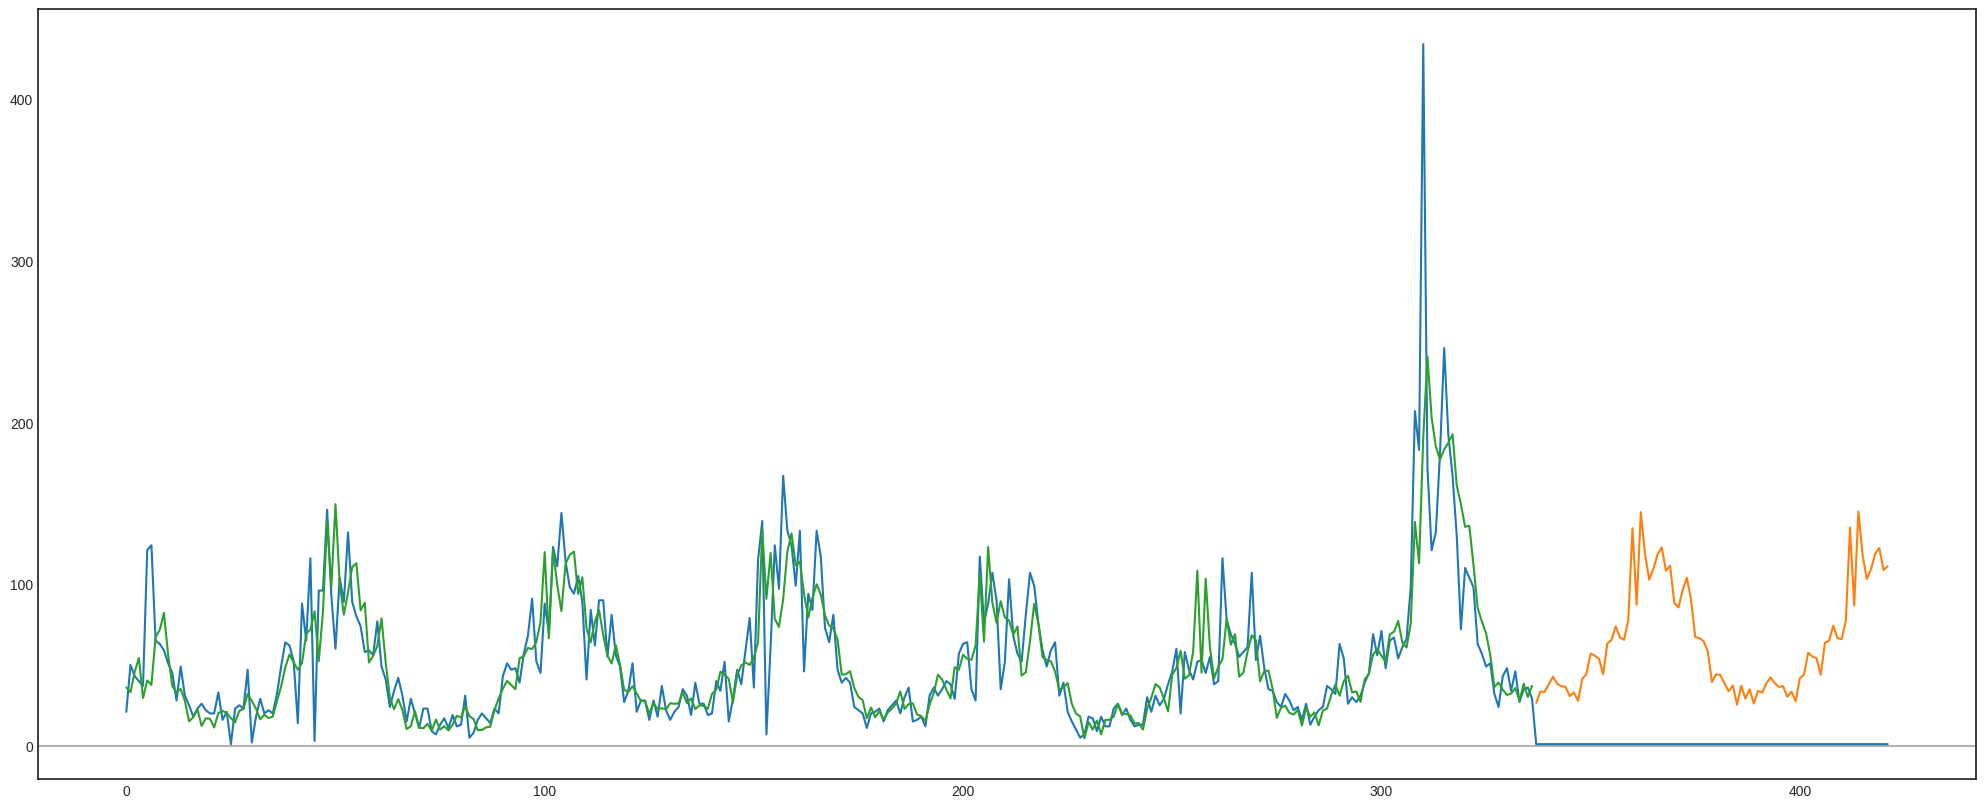

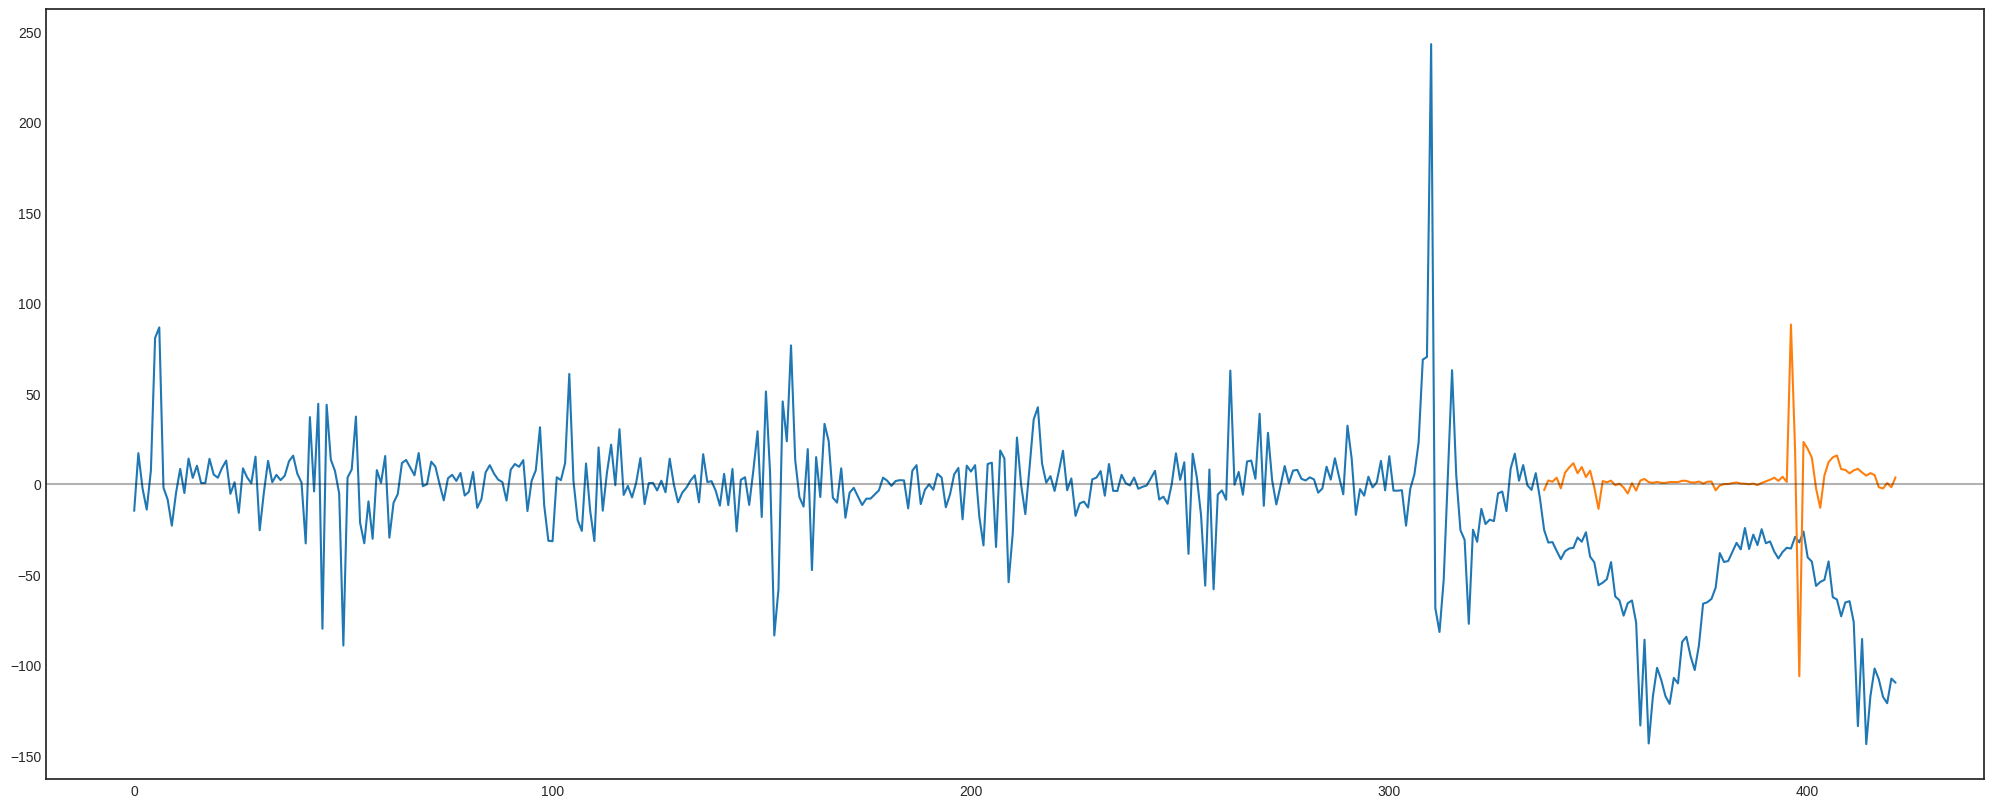

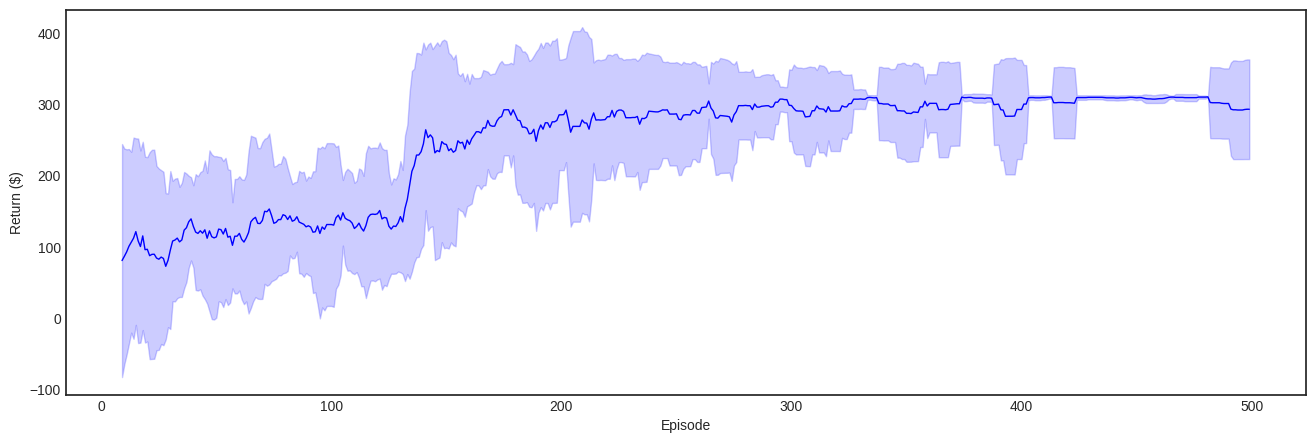

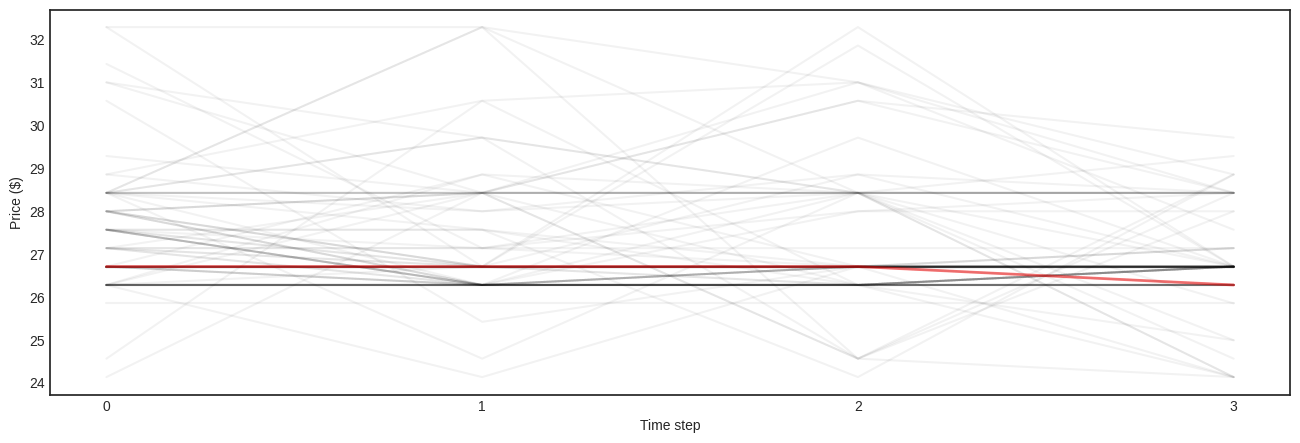

month: 0 week: 0 26.701724202649316 24.12674028949901
month: 0 week: 1 26.701724202649316 24.12674028949901
month: 0 week: 2 26.701724202649316 24.12674028949901
month: 0 week: 3 26.272560217124266 24.12674028949901
month: 1 week: 0 26.701724202649316 24.12674028949901
month: 1 week: 1 26.701724202649316 24.12674028949901
month: 1 week: 2 26.701724202649316 24.12674028949901
month: 1 week: 3 26.272560217124266 24.12674028949901
month: 2 week: 0 26.272560217124266 24.12674028949901
month: 2 week: 1 26.272560217124266 24.12674028949901
month: 2 week: 2 26.272560217124266 24.12674028949901
month: 2 week: 3 26.701724202649316 24.12674028949901
month: 3 week: 0 26.272560217124266 24.12674028949901
month: 3 week: 1 26.272560217124266 24.12674028949901
month: 3 week: 2 27.560052173699418 24.12674028949901
month: 3 week: 3 26.701724202649316 24.12674028949901
month: 4 week: 0 26.272560217124266 24.12674028949901
month: 4 week: 1 26.701724202649316 24.12674028949901
month: 4 week: 2 26.70172420

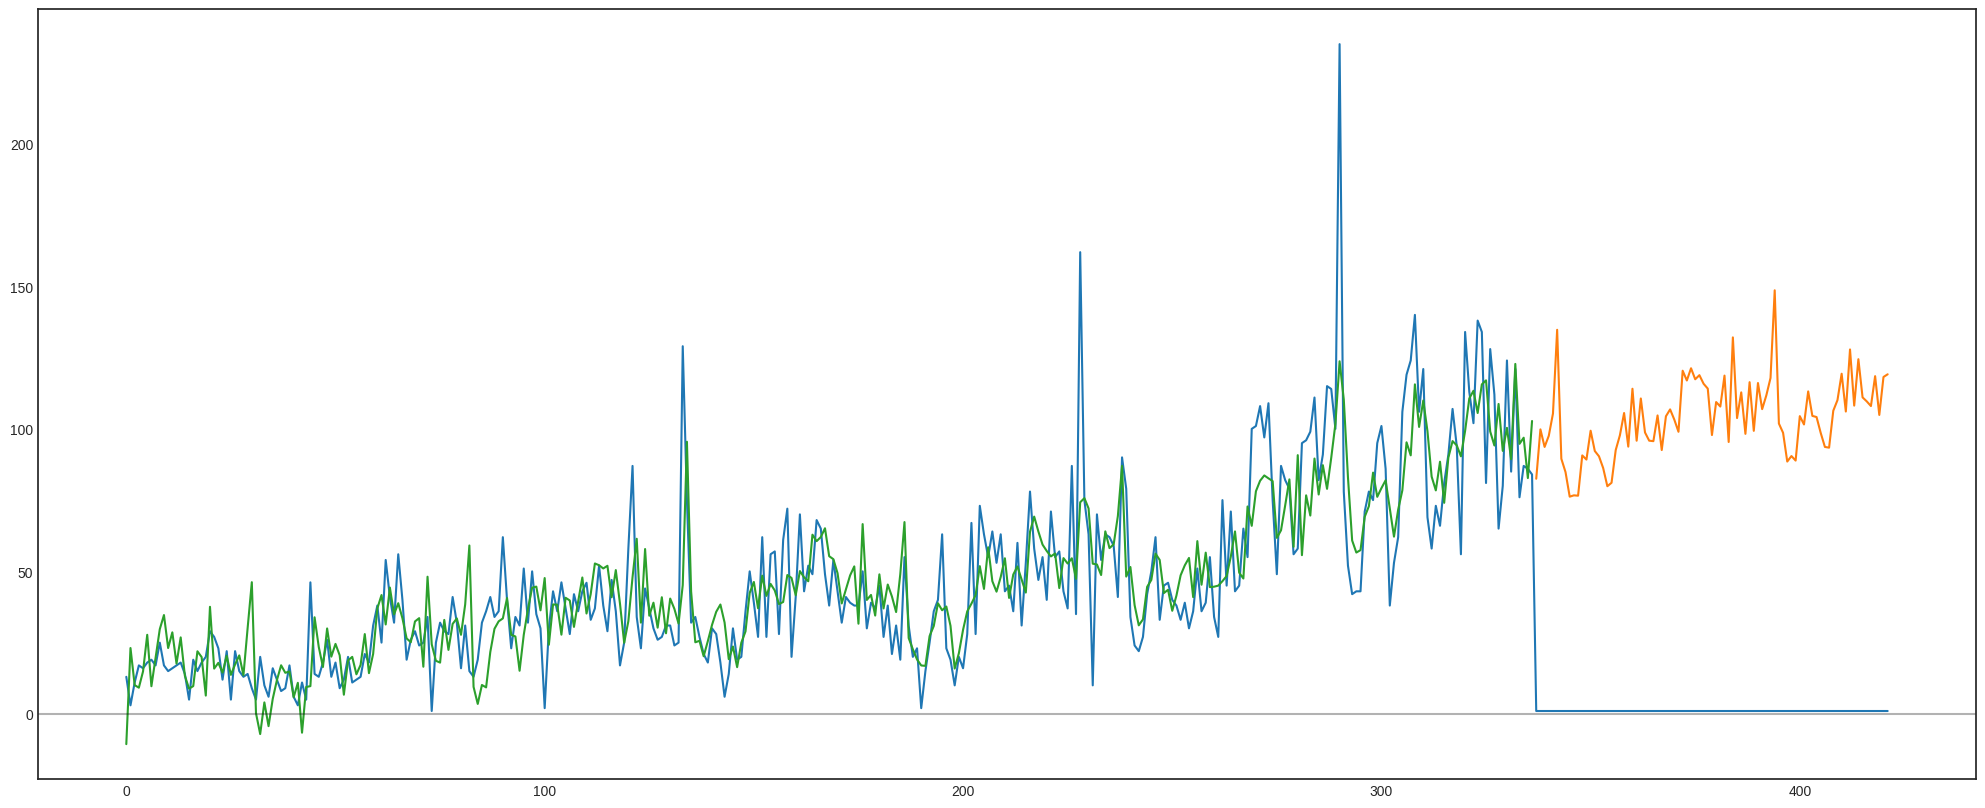

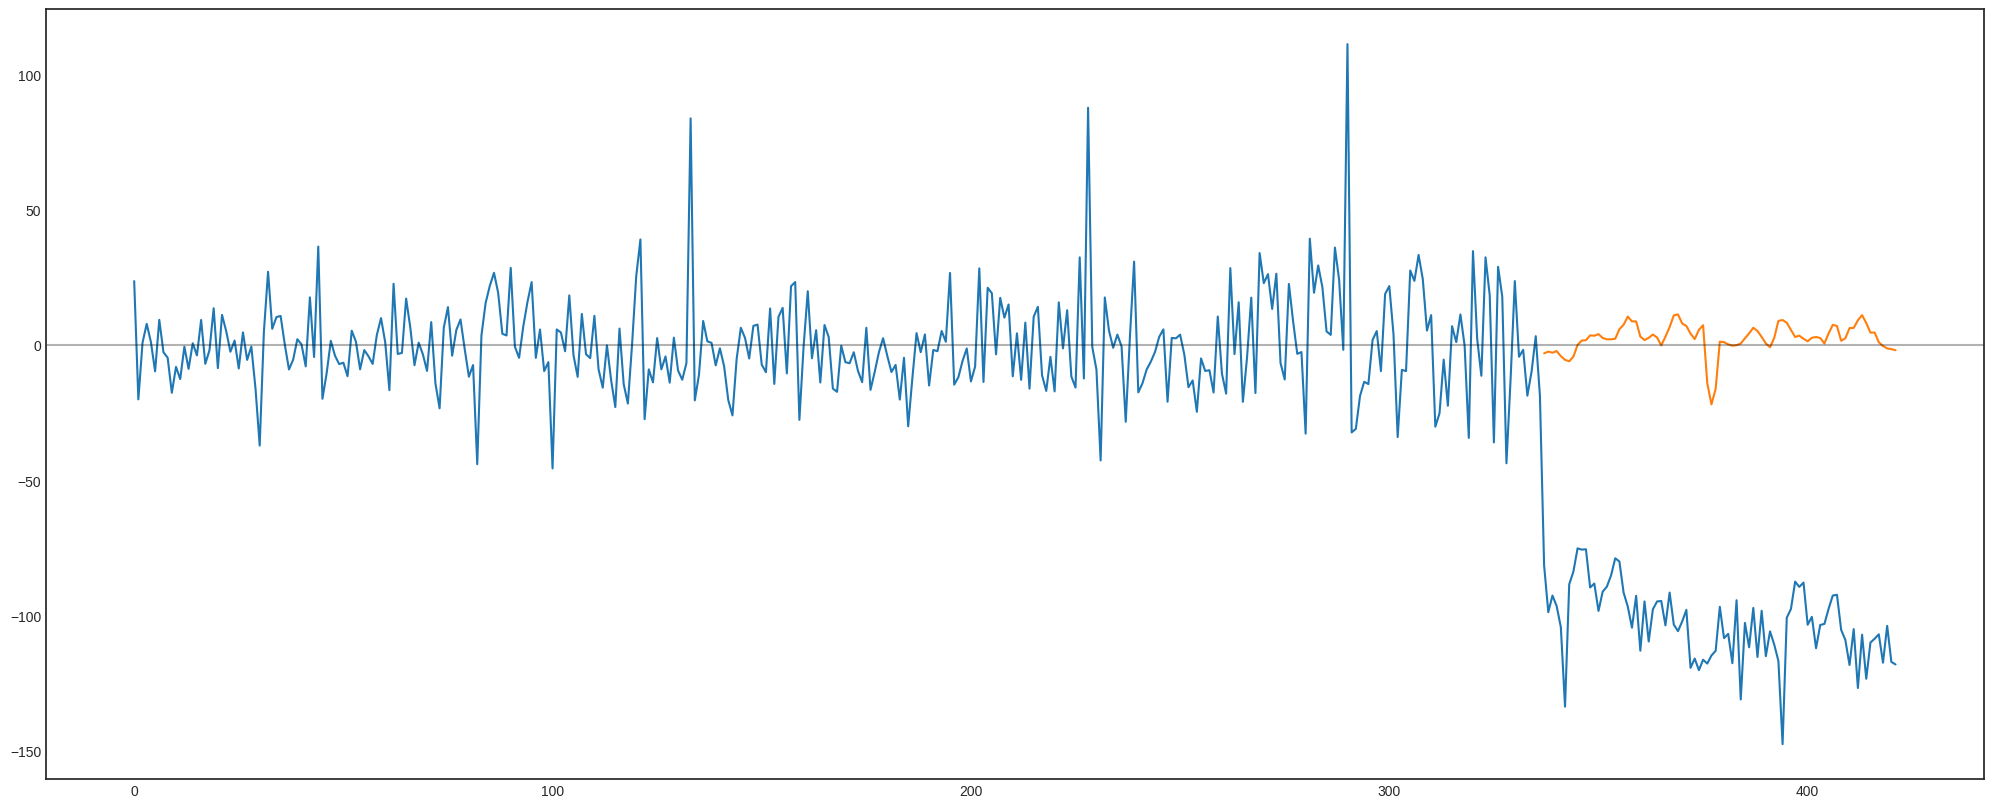

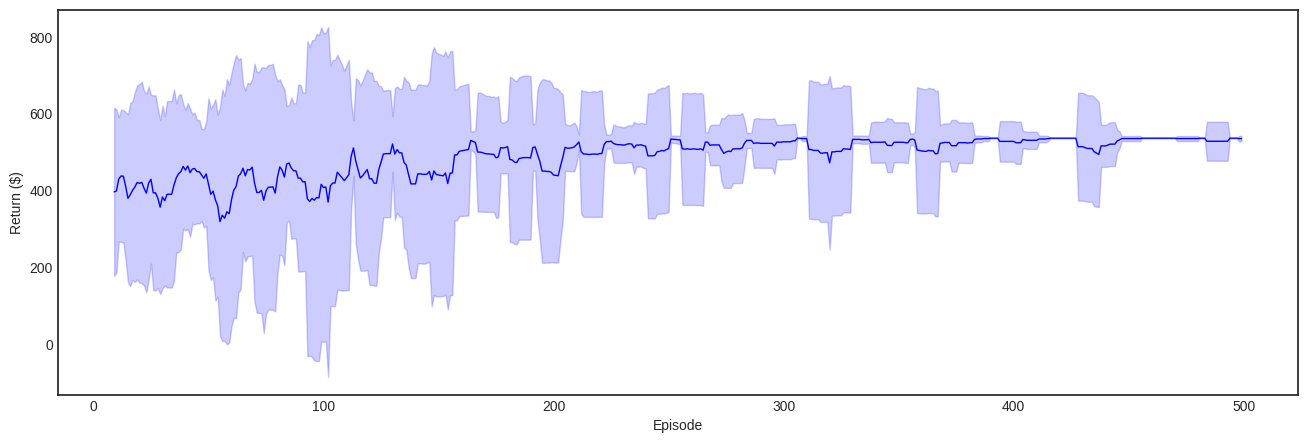

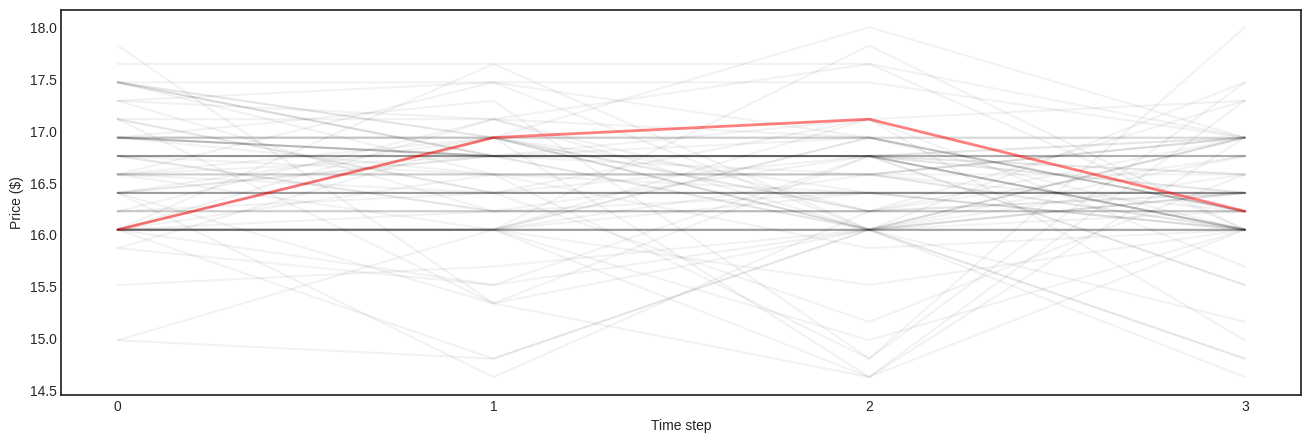

month: 0 week: 0 16.046297728607335 14.624197547678884
month: 0 week: 1 16.93511034168762 14.624197547678884
month: 0 week: 2 17.112872864303675 14.624197547678884
month: 0 week: 3 16.224060251223392 14.624197547678884
month: 1 week: 0 16.223323151223383 14.624197547678884
month: 1 week: 1 16.223323151223383 14.624197547678884
month: 1 week: 2 16.223323151223383 14.624197547678884
month: 1 week: 3 16.223323151223383 14.624197547678884
month: 2 week: 0 16.578684396455493 14.624197547678884
month: 2 week: 1 16.223323151223383 14.624197547678884
month: 2 week: 2 16.756365019071545 14.624197547678884
month: 2 week: 3 16.401003773839435 14.624197547678884
month: 3 week: 0 16.384413019071545 14.624197547678884
month: 3 week: 1 16.384413019071545 14.624197547678884
month: 3 week: 2 15.65098990599127 14.624197547678884
month: 3 week: 3 16.384413019071545 14.624197547678884
month: 4 week: 0 16.824466886919712 14.624197547678884
month: 4 week: 1 16.824466886919712 14.624197547678884
month: 4 wee

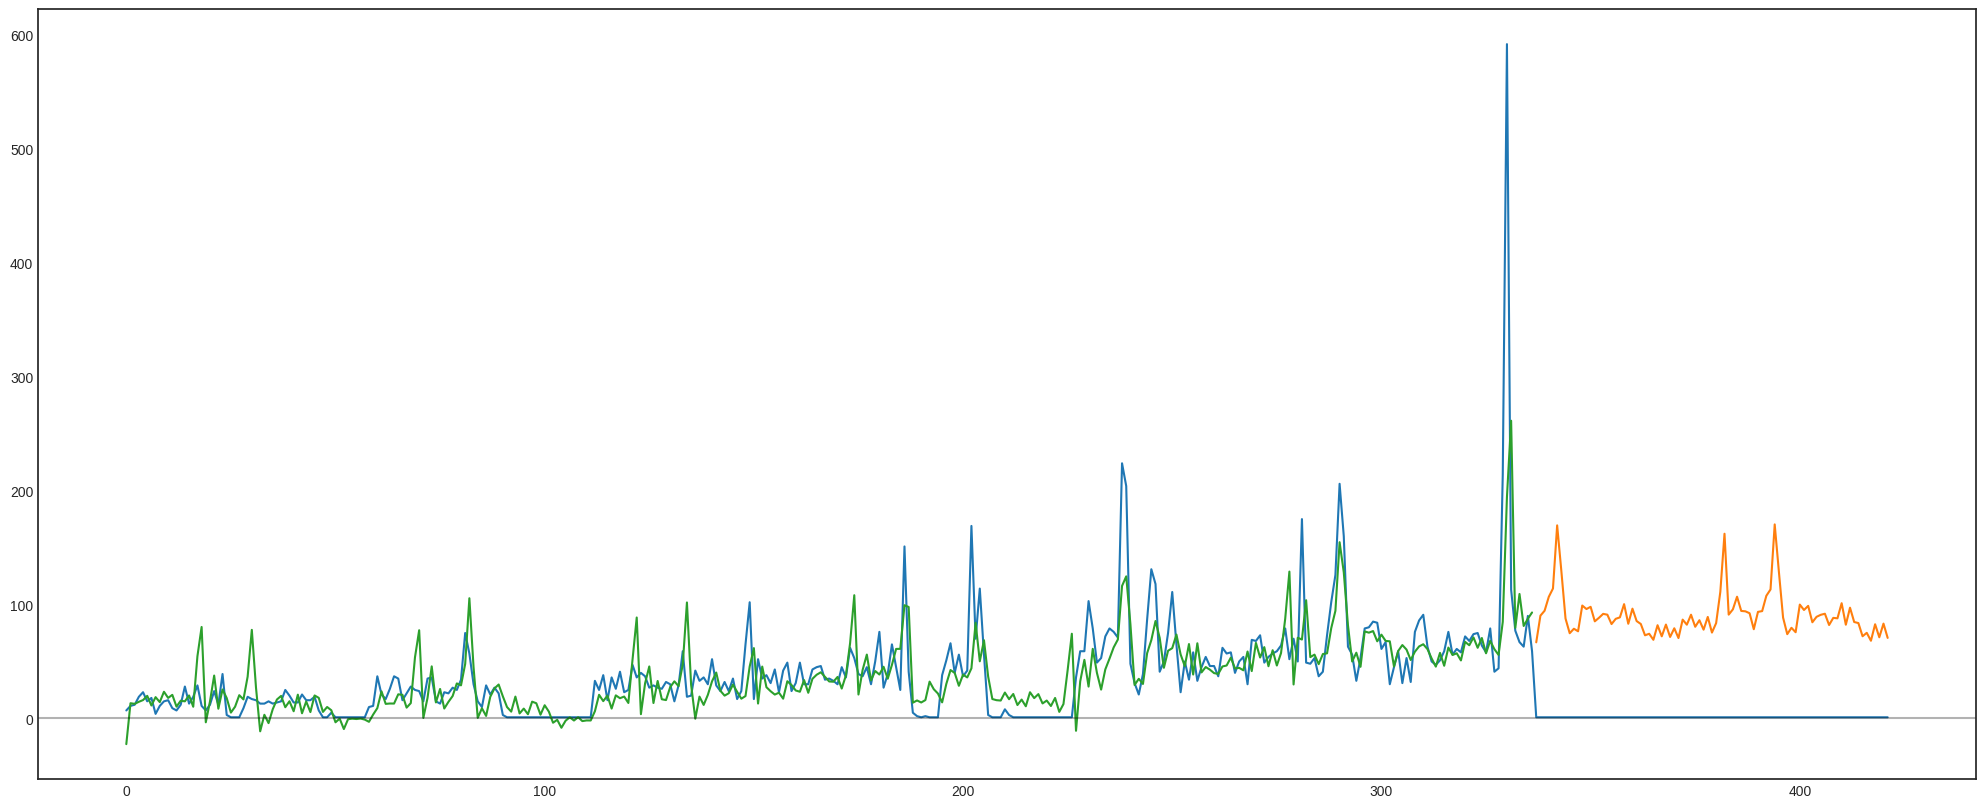

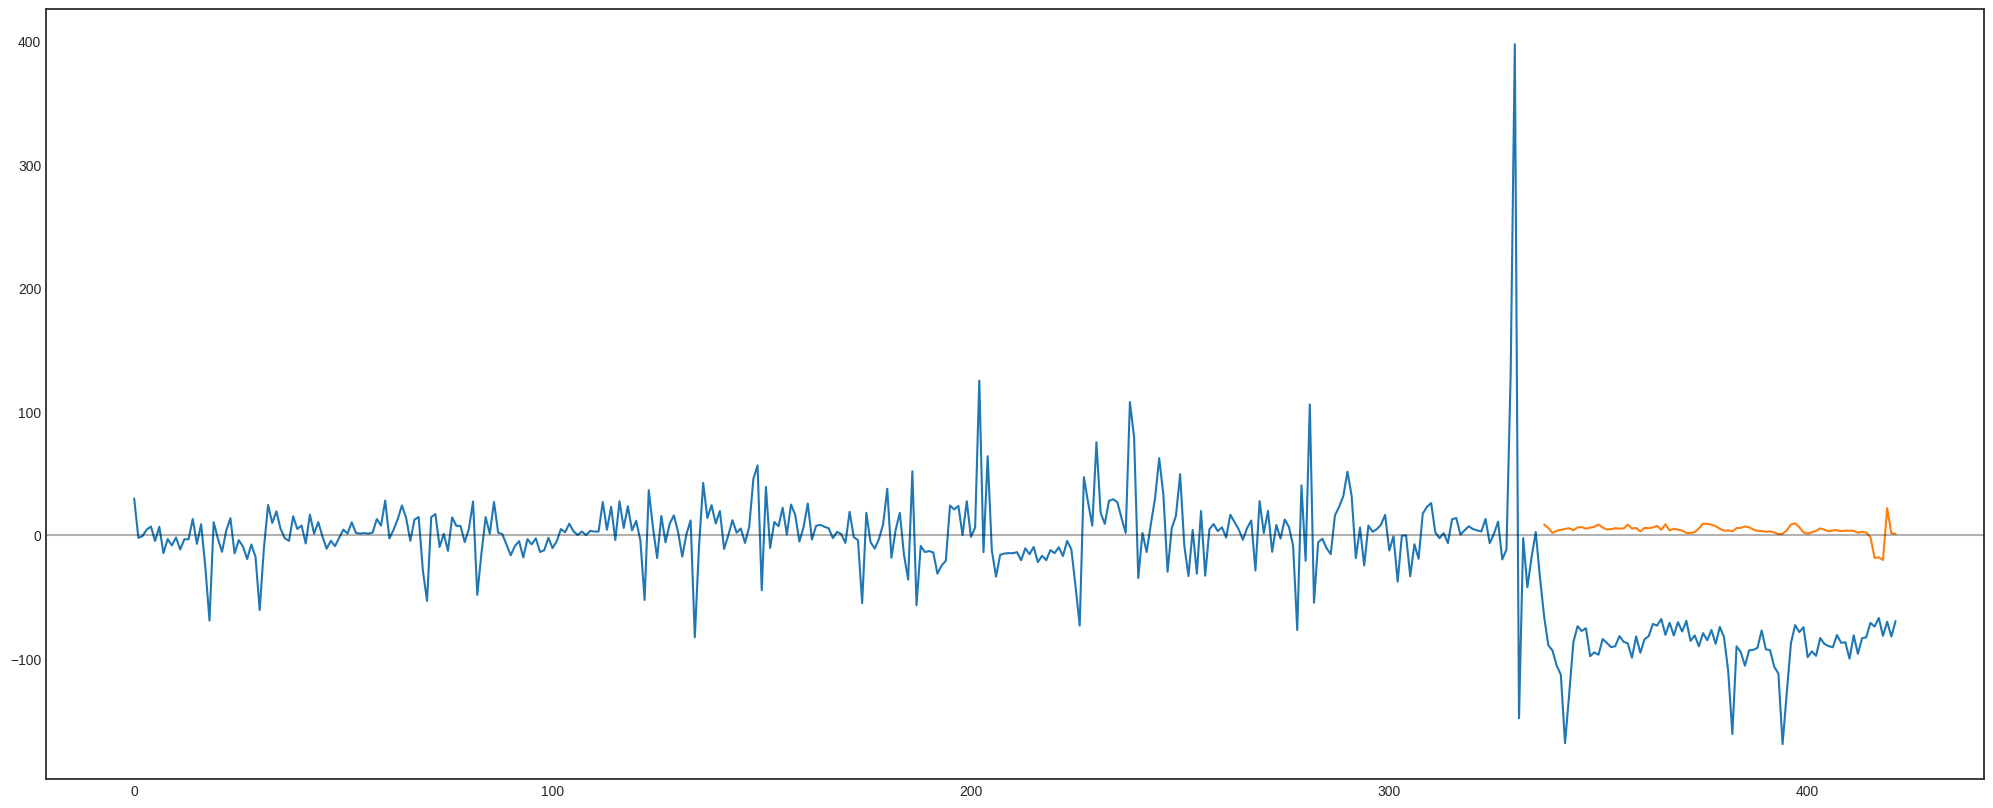

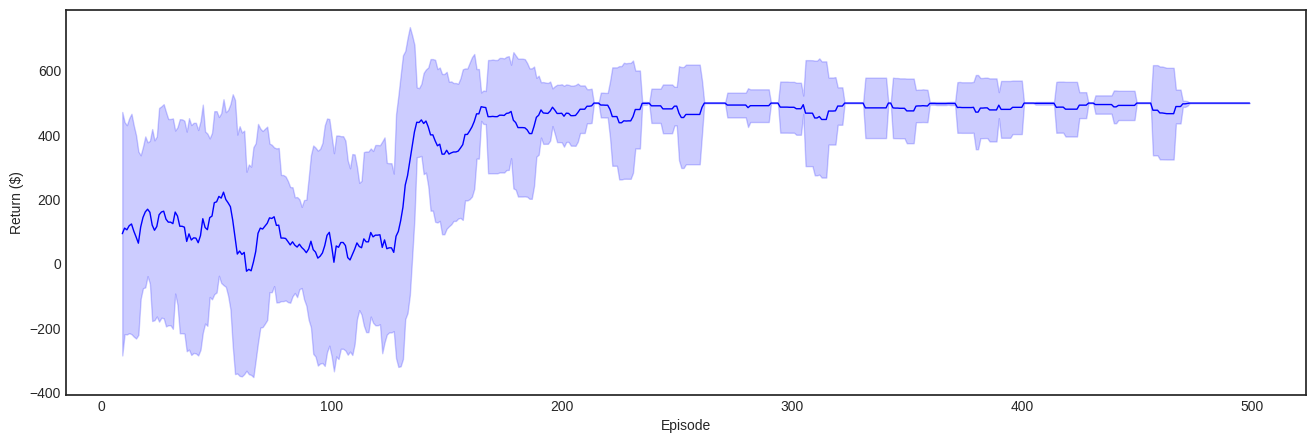

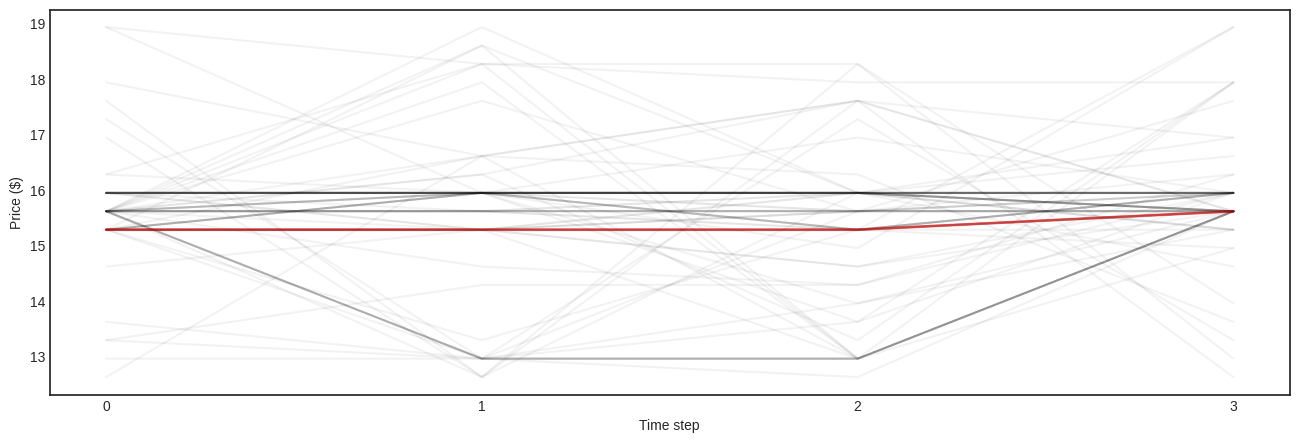

month: 0 week: 0 15.282216762728869 12.624791271214779
month: 0 week: 1 15.282216762728869 12.624791271214779
month: 0 week: 2 15.282216762728869 12.624791271214779
month: 0 week: 3 15.61439494916813 12.624791271214779
month: 1 week: 0 14.285682203411085 12.624791271214779
month: 1 week: 1 14.285682203411085 12.624791271214779
month: 1 week: 2 14.617860389850346 12.624791271214779
month: 1 week: 3 14.950038576289607 12.624791271214779
month: 2 week: 0 14.93317885753961 12.624791271214779
month: 2 week: 1 14.273639547161087 12.624791271214779
month: 2 week: 2 16.58202713348592 12.624791271214779
month: 2 week: 3 14.93317885753961 12.624791271214779
month: 3 week: 0 14.075035328411085 12.624791271214779
month: 3 week: 1 14.365084139850346 12.624791271214779
month: 3 week: 2 14.655132951289607 12.624791271214779
month: 3 week: 3 14.655132951289607 12.624791271214779
month: 4 week: 0 14.024613453411085 12.624791271214779
month: 4 week: 1 14.024613453411085 12.624791271214779
month: 4 week:

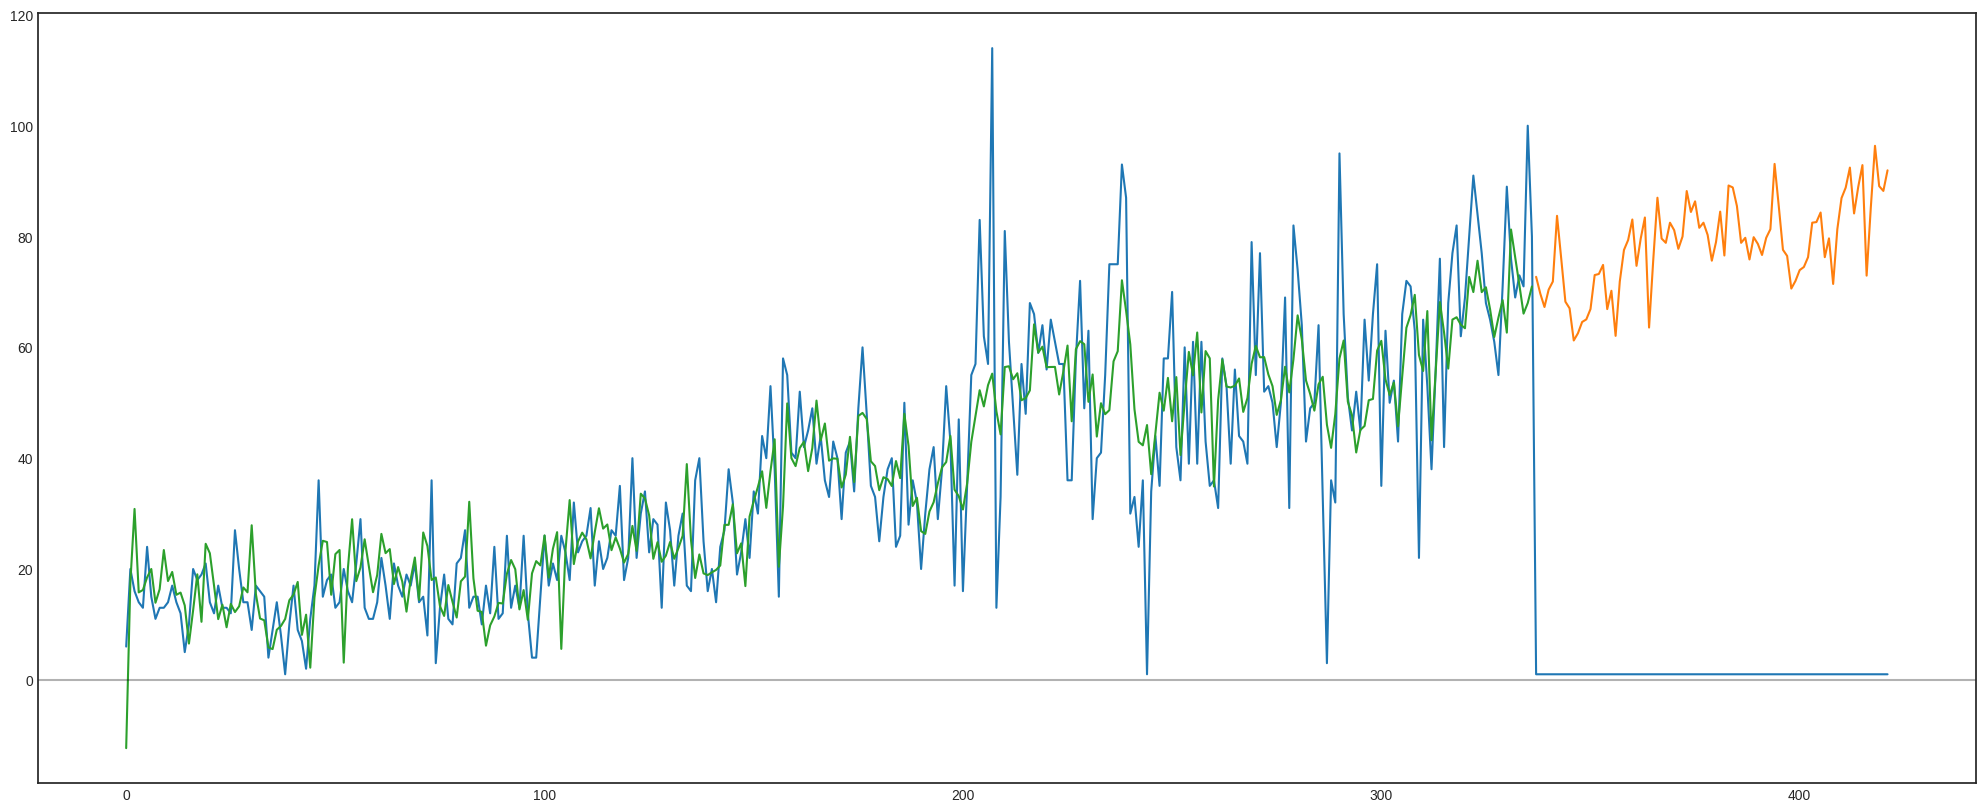

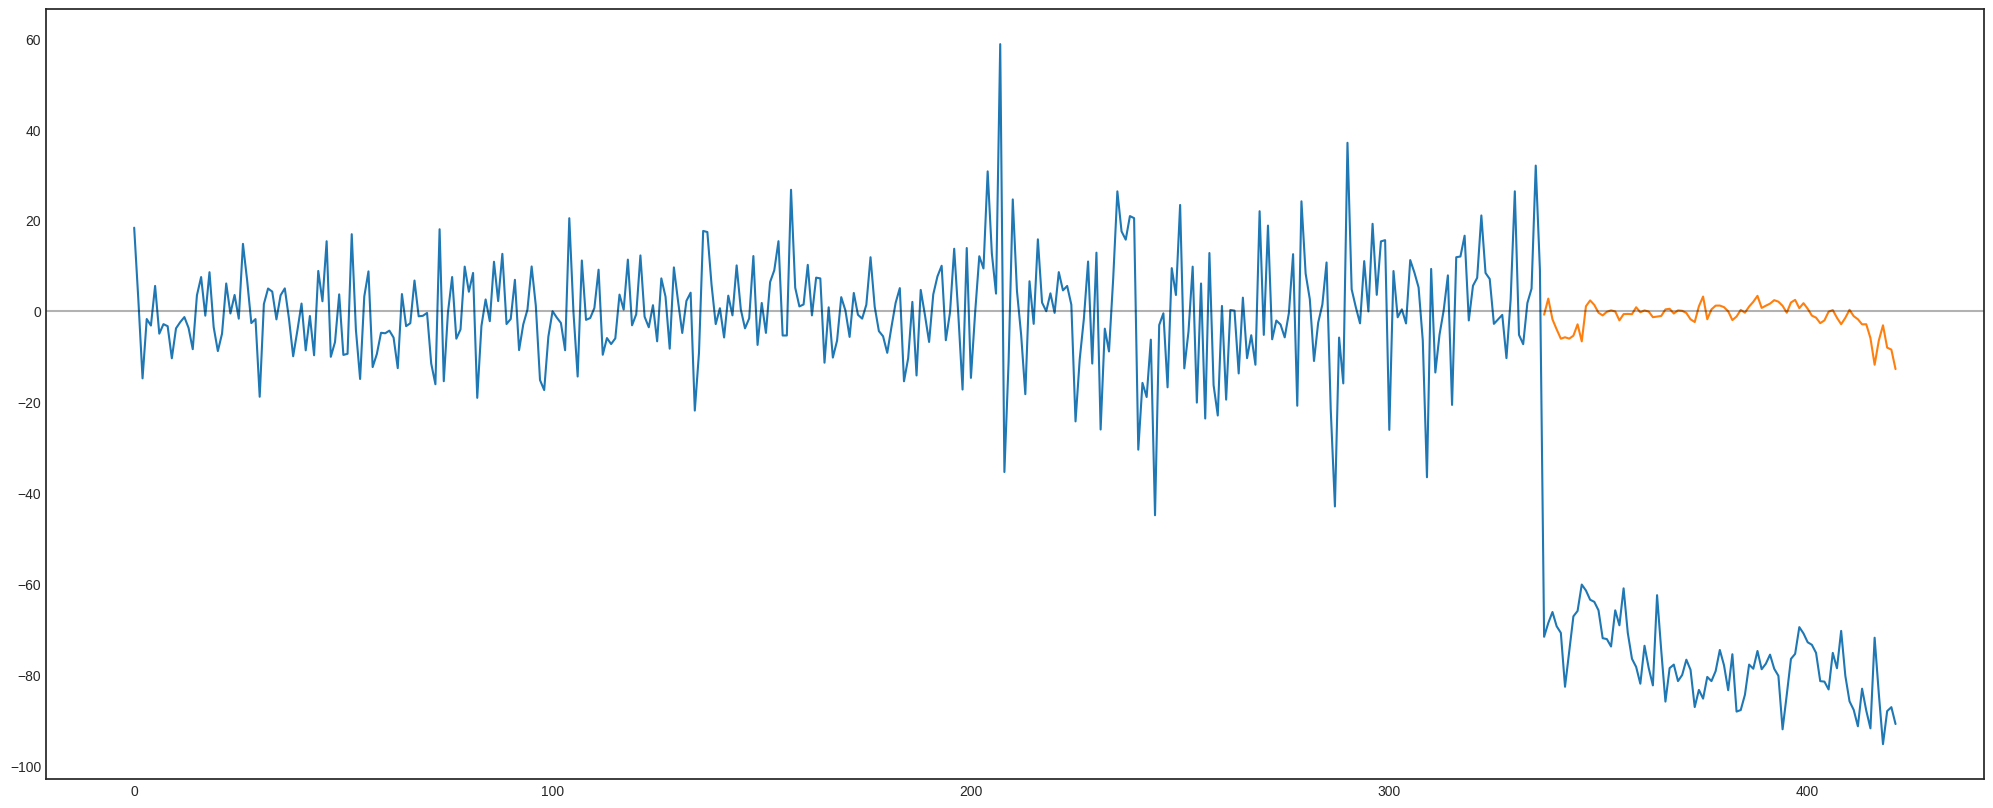

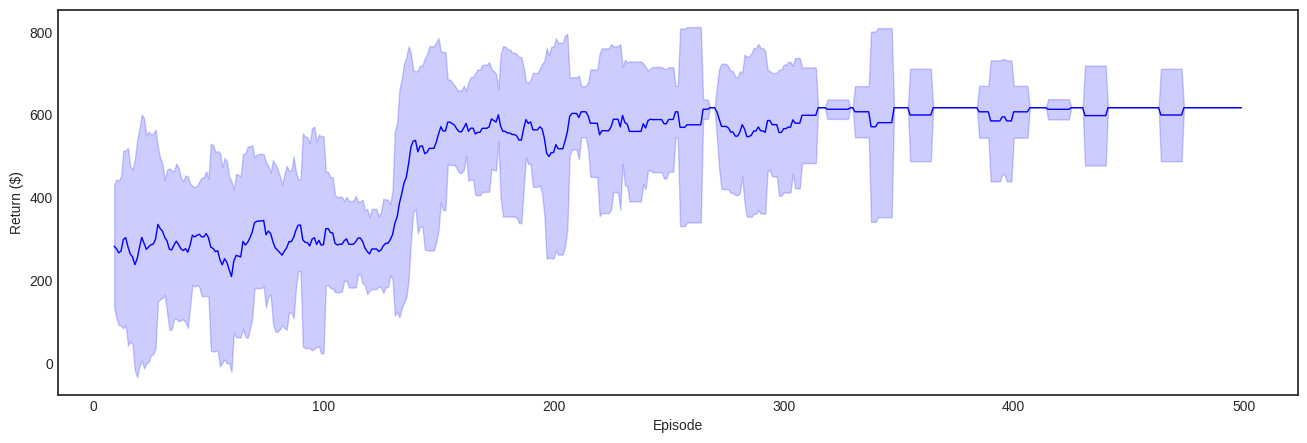

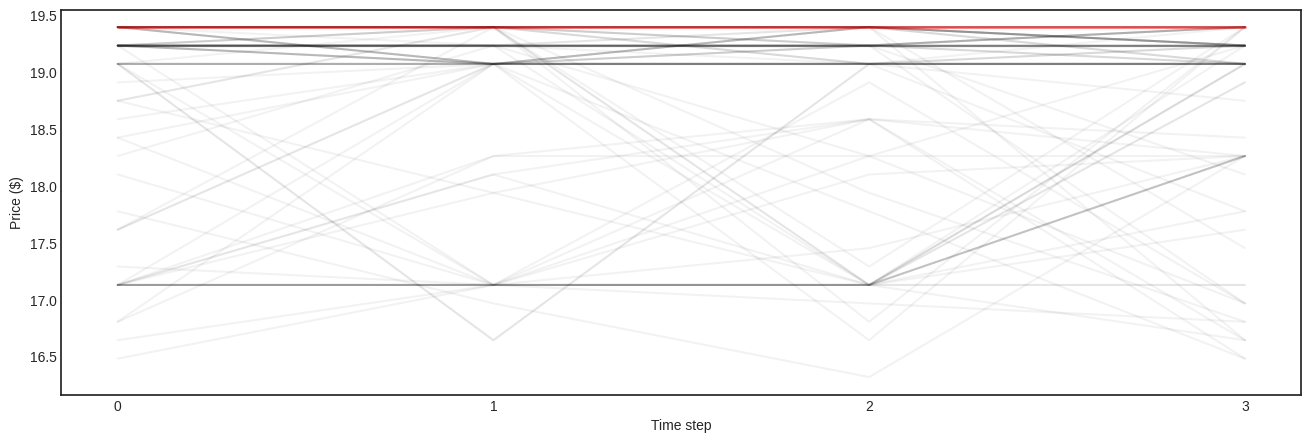

month: 0 week: 0 19.398520418213426 16.317868364268346
month: 0 week: 1 19.398520418213426 16.317868364268346
month: 0 week: 2 19.398520418213426 16.317868364268346
month: 0 week: 3 19.398520418213426 16.317868364268346
month: 1 week: 0 19.236380836426843 16.317868364268346
month: 1 week: 1 19.236380836426843 16.317868364268346
month: 1 week: 2 19.398520418213426 16.317868364268346
month: 1 week: 3 19.398520418213426 16.317868364268346
month: 2 week: 0 19.236380836426843 16.317868364268346
month: 2 week: 1 19.236380836426843 16.317868364268346
month: 2 week: 2 19.398520418213426 16.317868364268346
month: 2 week: 3 19.398520418213426 16.317868364268346
month: 3 week: 0 19.07424125464026 16.317868364268346
month: 3 week: 1 19.07424125464026 16.317868364268346
month: 3 week: 2 19.07424125464026 16.317868364268346
month: 3 week: 3 19.236380836426843 16.317868364268346
month: 4 week: 0 19.07424125464026 16.317868364268346
month: 4 week: 1 18.263543345707344 16.317868364268346
month: 4 week:

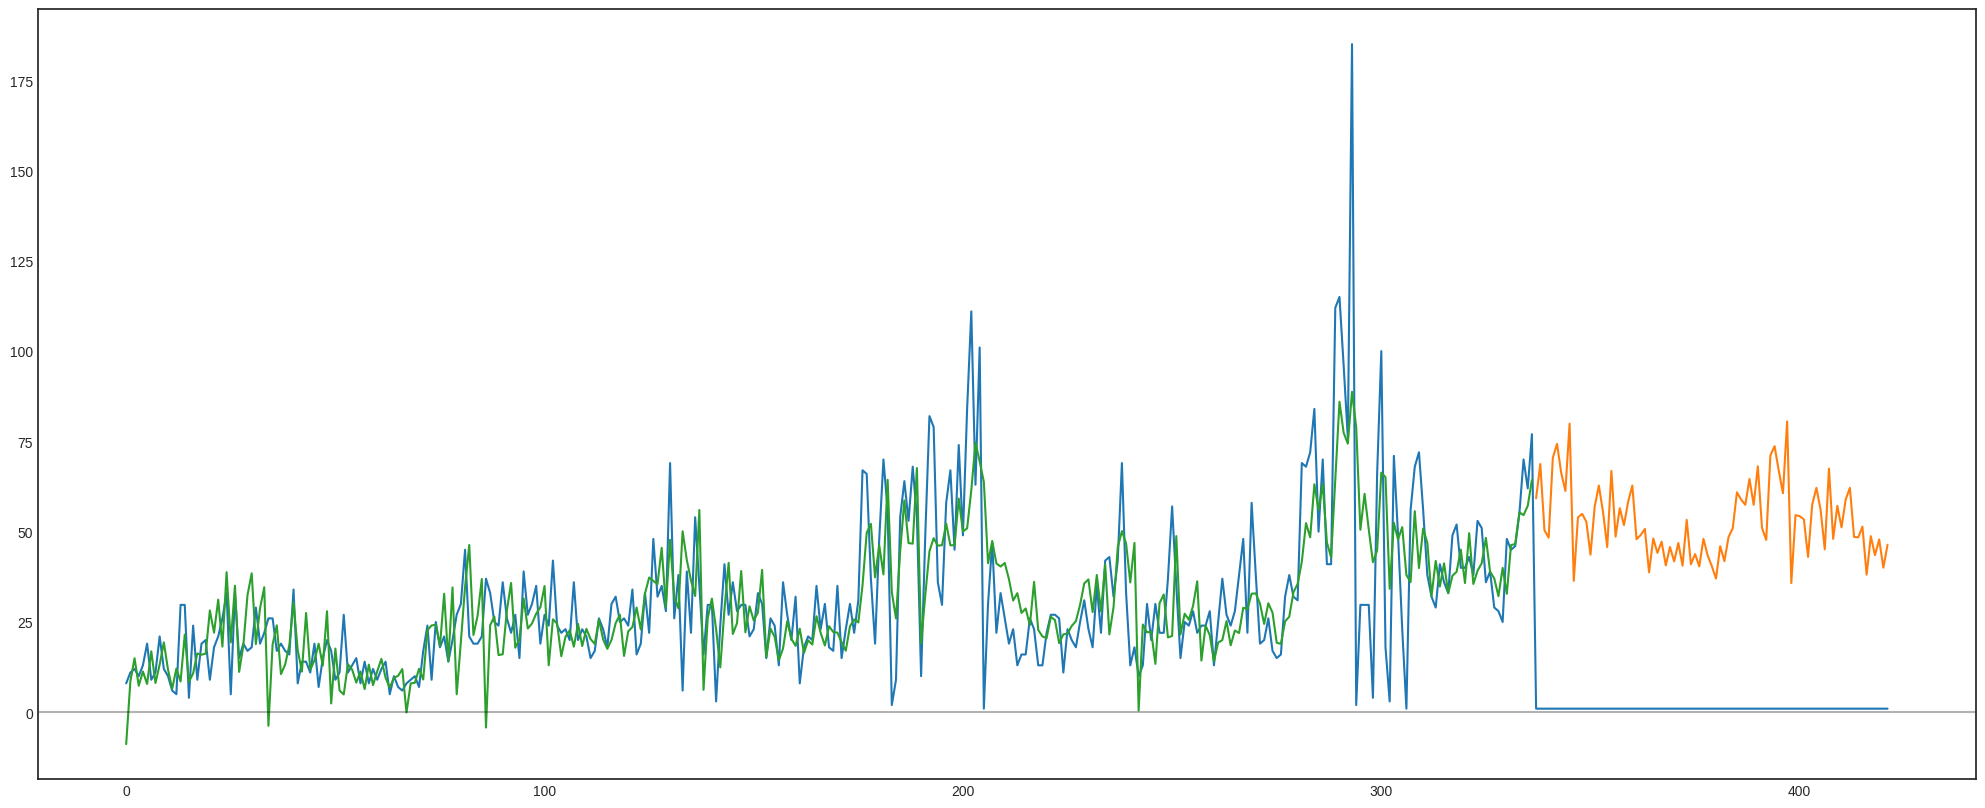

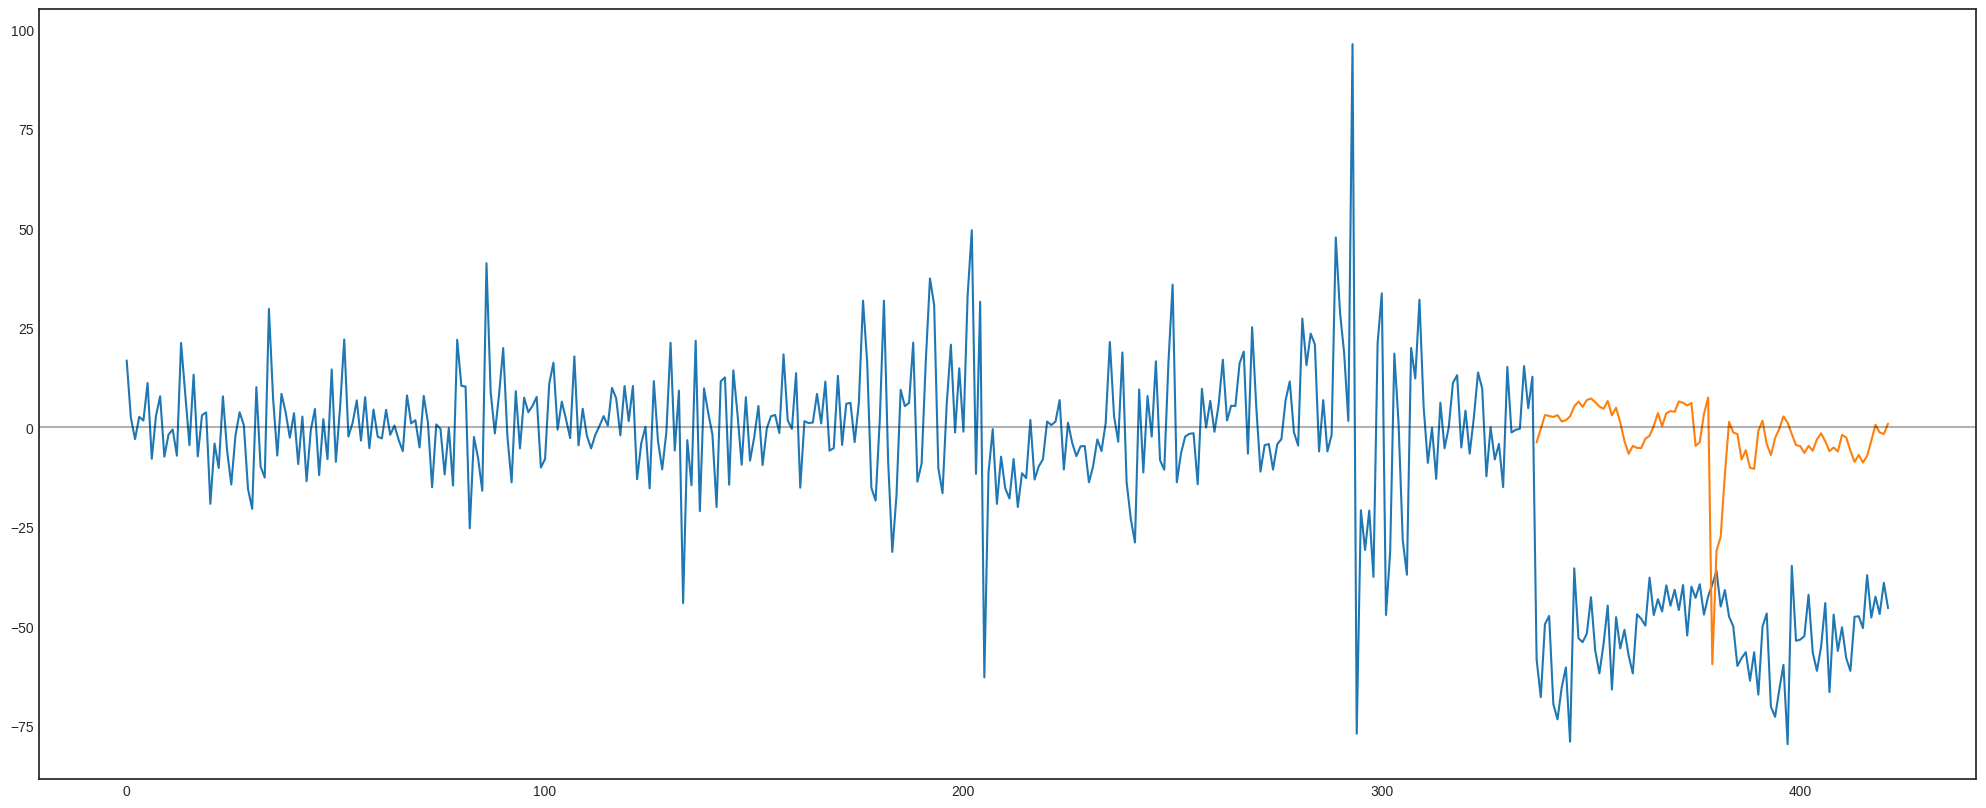

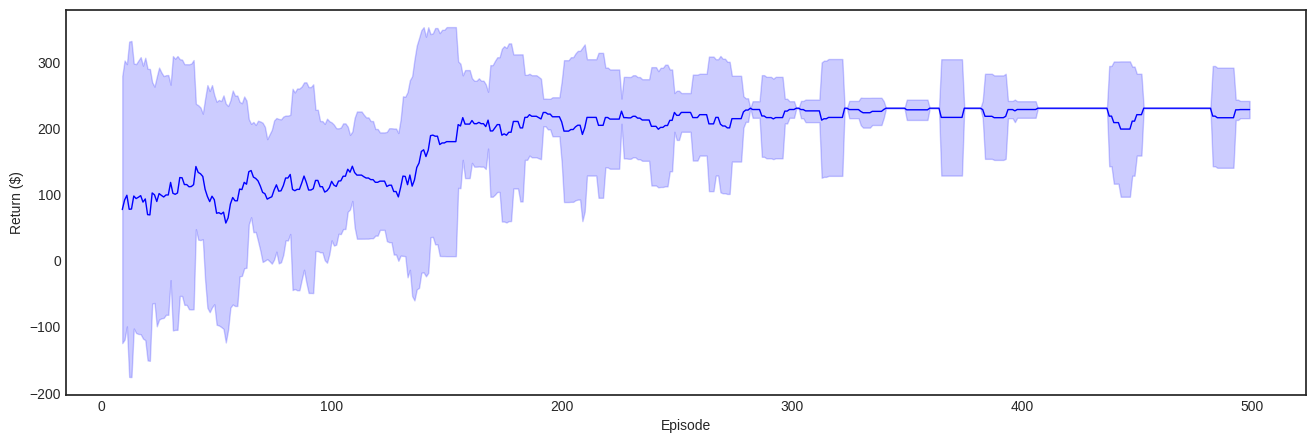

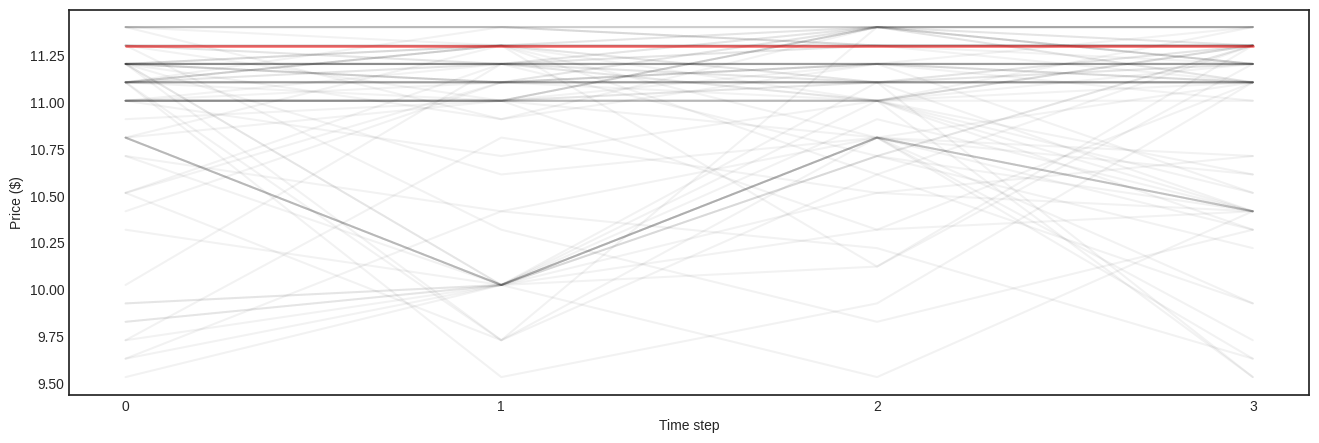

month: 0 week: 0 11.301388573678372 9.532314967552859
month: 0 week: 1 11.301388573678372 9.532314967552859
month: 0 week: 2 11.301388573678372 9.532314967552859
month: 0 week: 3 11.301388573678372 9.532314967552859
month: 1 week: 0 11.006542972657453 9.532314967552859
month: 1 week: 1 11.399670440685345 9.532314967552859
month: 1 week: 2 11.399670440685345 9.532314967552859
month: 1 week: 3 11.399670440685345 9.532314967552859
month: 2 week: 0 11.006542972657453 9.532314967552859
month: 2 week: 1 11.006542972657453 9.532314967552859
month: 2 week: 2 11.006542972657453 9.532314967552859
month: 2 week: 3 11.006542972657453 9.532314967552859
month: 3 week: 0 11.006542972657453 9.532314967552859
month: 3 week: 1 11.006542972657453 9.532314967552859
month: 3 week: 2 11.203106706671399 9.532314967552859
month: 3 week: 3 11.203106706671399 9.532314967552859
month: 4 week: 0 11.399670440685345 9.532314967552859
month: 4 week: 1 11.399670440685345 9.532314967552859
month: 4 week: 2 11.20310670

In [ ]:

final=pd.DataFrame(columns=['Shop0','Shop1','Shop2','Shop3'])
df_final=pd.DataFrame()

for i in sorted.SKU[0:5]:
  df=data.item(i)
  mu=df['price_per_unit'][len(df)-10:].mean()
  cost=mu*0.8
  df_shops=create_shops(cost)
  min=df_shops.Price[1:].min()
  avg=df_shops.Price[1:].mean()



  complete,arima,bilastm,metrics,pipe=hybrid.predict(df,plot_graphs=True,training=False,Price=0)
  dqn_prices=dqn.predict(df,arima,calc_elasticity.PED(df),4,min,avg,cost,True)


  for month in range (0,6):

    for week in range (0,4):
      print('month:',month,'week:',week,dqn_prices[0][week],cost)

      df_shops=create_shops(cost)
      df_shops.Price[0]=dqn_prices[0][week]

      customers=simulate_customers(df_shops.Price.mean())
      profits,sales=market_simulation(df_shops,customers,cost)
      final.loc[len(final)]=profits
      new_row = {'products_quantity':sales, 'price_per_unit':dqn_prices[0][week], 'lianikiMeFpaAfterDiscount':df_shops.Price.mean(), 'Market Sales (Quantity)':10000}
      df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
      pipe.update([sales])


    prediction= pipe.predict(4)
    min=df_shops.Price[1:].min()
    avg=df_shops.Price[1:].mean()
    dqn_prices=dqn.predict(df,pd.DataFrame(prediction),calc_elasticity.PED(df),4,min,avg,cost,False)
  new_row = {'i':final.sum().tolist()}
  df_final = pd.concat([df_final, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
final.sum()

Shop0    207393.130951
Shop1    231189.079523
Shop2    181799.479723
Shop3    120690.039378
dtype: float64

In [ ]:
final.sum()

Shop0    252884.935373
Shop1    260886.719065
Shop2    248030.609944
Shop3    181709.815017
dtype: float64

In [ ]:
final.sum()

Shop0    282655.326450
Shop1    274097.005014
Shop2    309894.158185
Shop3    261051.381806
dtype: float64

In [ ]:
final.sum()

Shop0    262704.219823
Shop1    263792.837127
Shop2    269644.101333
Shop3    211641.782724
dtype: float64

In [ ]:
for i in sorted.SKU[0:5]:
  df=data.item(i)
  print(calc_elasticity.PED(df))

-6.520889926351736
-0.3533944739650881
-4.713156517122941
-2.5777242274154233
-0.12432754677248853
